Importing relevant libraries

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

In [3]:
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Loading data into Pandas, renaming the columns

In [4]:
cc = pd.read_csv('UCI_Credit_Card.csv', header=None,
                  names=['CustId','Limit','Sex','Edu','Marital_Status','Age','Repay_Sep','Repay_Aug','Repay_Jul','Repay_Jun',
                        'Repay_May','Repay_Apr','Bill_Sep','Bill_Aug','Bill_Jul','Bill_Jun','Bill_May','Bill_Apr','Pay_Sep',
                        'Pay_Aug','Pay_Jul','Pay_Jun','Pay_May','Pay_Apr','Default_Nxt_Mnth'])
cc_data = cc[cc.Sex != 'SEX']
cc_data.head(5)

,CustId,Limit,Sex,Edu,Marital_Status,Age,Repay_Sep,Repay_Aug,Repay_Jul,Repay_Jun,...,Bill_Jun,Bill_May,Bill_Apr,Pay_Sep,Pay_Aug,Pay_Jul,Pay_Jun,Pay_May,Pay_Apr,Default_Nxt_Mnth
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Dividing the dataset into features and labels - eliminating unique identifier

In [5]:
#Dividing the data into X and Y
cc_data = cc_data.apply(lambda x: pd.to_numeric(x, errors='ignore'))
cc_features = pd.DataFrame(cc_data.iloc[:,1 :-1].as_matrix(),
                 columns = ['Limit','Sex','Edu','Marital_Status','Age','Repay_Sep','Repay_Aug','Repay_Jul','Repay_Jun',
                        'Repay_May','Repay_Apr','Bill_Sep','Bill_Aug','Bill_Jul','Bill_Jun','Bill_May','Bill_Apr','Pay_Sep',
                        'Pay_Aug','Pay_Jul','Pay_Jun','Pay_May','Pay_Apr'])
cc_labels = pd.DataFrame(cc_data.iloc[:, [-1]].as_matrix(), 
                 columns=['Default_Nxt_Mnth'])
cc_features_labels = pd.concat((cc_features, cc_labels), axis=1)
print ("Number of observations: {}\nNumber of features {}".\
    format(cc_features.shape[0], cc_features.shape[1]))

Number of observations: 30000
Number of features 23


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Spliting the data into 72% Train, 18%validation and 10% test

In [7]:
#Split into train_validation & Test - 90% 10% respectively
cc_train_validation, cc_test, cc_label_train_validation, cc_label_test = train_test_split(cc_features, 
                                                                                          cc_labels, 
                                                                                          test_size = 0.1, 
                                                                                          random_state = 0)

In [8]:
#Split the train validation 80% 20%
cc_train, cc_validation, cc_label_train, cc_label_validation = train_test_split(cc_train_validation, 
                                                                cc_label_train_validation, 
                                                                test_size = 0.2, 
                                                                random_state = 0)


Identifying the K best correlated features by using null to full method

In [9]:
# Identify best K features using null to full method
current_MSE = ((cc_label_train - cc_label_train.mean())**2).mean()[0] #Initial MSE
current_model_vars = set() #Initial set of variables used
p = cc_train.shape[1] #Number of features 23

for k in range(p):
    possible_next_vars = list(set(range(p)) - current_model_vars)
    next_model_vars = current_model_vars
    for next_var in possible_next_vars:
        list(current_model_vars) + [next_var]
        model = LinearRegression().fit(cc_train.iloc[:, list(current_model_vars) + [next_var]], cc_label_train)
        model_validation_err = \
        ((model.predict(cc_validation.iloc[:, list(current_model_vars) + [next_var]]) - cc_label_validation)**2).mean()[0]
        if model_validation_err < current_MSE:
            next_model_vars = current_model_vars.union(set([next_var]))
            current_MSE = model_validation_err
    if next_model_vars == current_model_vars:
        break
    else:        
        print("Selecting ", str(cc_train.columns[list(next_model_vars - current_model_vars)]))
        current_model_vars = next_model_vars


Selecting  Index(['Repay_Sep'], dtype='object')
Selecting  Index(['Bill_Sep'], dtype='object')
Selecting  Index(['Repay_Aug'], dtype='object')
Selecting  Index(['Age'], dtype='object')
Selecting  Index(['Sex'], dtype='object')
Selecting  Index(['Marital_Status'], dtype='object')
Selecting  Index(['Edu'], dtype='object')
Selecting  Index(['Pay_May'], dtype='object')
Selecting  Index(['Repay_Jun'], dtype='object')
Selecting  Index(['Pay_Sep'], dtype='object')
Selecting  Index(['Limit'], dtype='object')
Selecting  Index(['Repay_Apr'], dtype='object')


In [10]:
#Final set of features - Repay_Sep, Bill_Sep, Repay_Aug, Repay_Jun, Repay_Apr,Age,Sex,Marital_Status,Edu,Pay_May,Pay_Sep,Limit
cc_train.columns[list(current_model_vars)]

Index(['Limit', 'Sex', 'Edu', 'Marital_Status', 'Age', 'Repay_Sep',
       'Repay_Aug', 'Repay_Jun', 'Repay_Apr', 'Bill_Sep', 'Pay_Sep',
       'Pay_May'],
      dtype='object')

Kick off machine learning with linear regression

In [11]:
#MSE for linear regression
linear_model = LinearRegression().fit(cc_train.iloc[:, list(current_model_vars)], cc_label_train)
((linear_model.predict(cc_test.iloc[:, list(current_model_vars)]) - cc_label_test)**2).mean()[0]

0.14679280736476286

In [12]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

Create sets of features using the 12 best correlated features

In [13]:
# We will create spurious features
cc_features_poly = StandardScaler().fit_transform(PolynomialFeatures(degree=2).fit_transform(cc_features.iloc[:, list(current_model_vars)]))
cc_features_poly.shape[1]

91

Finding the best suited feature set

In [14]:
#Cross validation for train and test
all_mse_train = []
all_mse_test = []
for _ in range(10):
    cc1_train, cc1_test, cc_label1_train, cc_label1_test = train_test_split(cc_features_poly, cc_labels.as_matrix(), test_size = 0.1)
    mse_train = []
    mse_test = []
    for k in range(cc1_train.shape[1]):
        idx_vars = np.random.choice(range(cc1_train.shape[1]), size=k+1)
        lm = LinearRegression().fit(cc1_train[:, idx_vars], cc_label1_train)
        mse_train.append(((cc_label1_train - lm.predict(cc1_train[:, idx_vars]))**2).mean())
        mse_test.append(((cc_label1_test - lm.predict(cc1_test[:, idx_vars]))**2).mean())
    all_mse_train.append(mse_train)
    all_mse_test.append(mse_test)
all_mse_train = np.array(all_mse_train)
all_mse_test = np.array(all_mse_test)

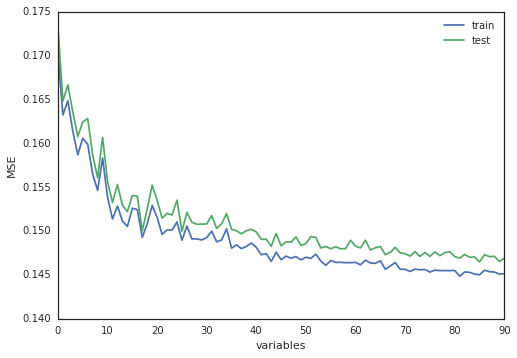

In [15]:
plt.plot(range(cc1_train.shape[1]), all_mse_train.mean(0), label='train');
plt.plot(range(cc1_train.shape[1]), all_mse_test.mean(0), label='test');
plt.legend();
plt.xlabel('variables');
plt.ylabel('MSE');

In [16]:
from sklearn.learning_curve import learning_curve

/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [17]:
def MSE_score(estimator, X, y):
    return ((estimator.predict(X) - y)**2).mean()[0]

Identifying optimum train size

In [18]:
train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), cc_features.iloc[:, list(current_model_vars)], cc_labels, scoring=MSE_score, cv  = 10)

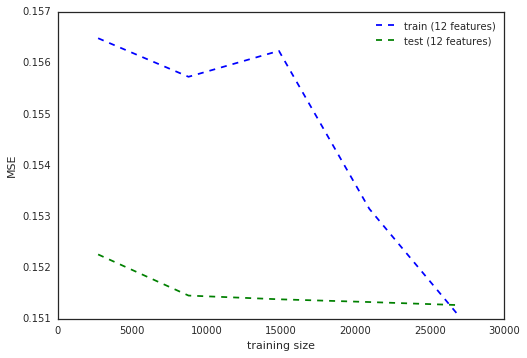

In [19]:
#Optimum train size 85%
plt.plot(train_sizes, train_scores.mean(1), 'b--', label='train (12 features)');
plt.plot(train_sizes, valid_scores.mean(1), 'g--', label='test (12 features)');
plt.legend();
plt.xlabel('training size');
plt.ylabel('MSE');

In [20]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm

Another approach to get K best features

In [21]:
#Selecting K Best features
X_best = SelectKBest(f_regression, k=12).fit_transform(cc_features, cc_labels)
X_best.shape[1]

12

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

Evaluating different models for Clasification - Supervised Machine Learning

In [23]:
nn3_model = KNeighborsRegressor(n_neighbors=3)
nn5_model = KNeighborsRegressor(n_neighbors=5)
nn7_model = KNeighborsRegressor(n_neighbors=7)
nn9_model = KNeighborsRegressor(n_neighbors=9)
decision_tree = tree.DecisionTreeRegressor()
clf = svm.LinearSVC()
rf = RandomForestRegressor()
gnb = GaussianNB()
kmean2_model = KMeans(n_clusters=2)
kmean5_model = KMeans(n_clusters=5)
kmean2_init_model = KMeans(n_clusters=2, n_init=1,init='random')

In [24]:
models = [ {'name' : '3-Nearest Neighbors', 'estimator' : nn3_model},
          {'name' : '5-Nearest Neighbors', 'estimator' : nn5_model},
          {'name' : '7-Nearest Neighbors', 'estimator' : nn7_model},
          {'name' : '9-Nearest Neighbors', 'estimator' : nn9_model},
          {'name' : 'KMeans 2 clusters', 'estimator' :kmean2_model},
          {'name' : 'KMeans 2 Clusters init', 'estimator' : kmean2_init_model},
          {'name' : 'Random Forest', 'estimator' : rf}
         ]

Using 12 best features

In [25]:
#Giving K best features for model evaluation with respect to Accuracy - R2 scoring
for model in models:
    scores = cross_val_score(model['estimator'], X_best, cc_labels, cv=10, scoring='r2' )
    print(" %s Accuracy: %0.2f (+/- %0.2f)" % (model['name'], scores.mean(), scores.std() * 2))

 3-Nearest Neighbors Accuracy: -0.20 (+/- 0.05)
 5-Nearest Neighbors Accuracy: -0.09 (+/- 0.06)
 7-Nearest Neighbors Accuracy: -0.04 (+/- 0.05)
 9-Nearest Neighbors Accuracy: -0.01 (+/- 0.05)
 KMeans 2 clusters Accuracy: -1.73 (+/- 0.64)
 KMeans 2 Clusters init Accuracy: -1.92 (+/- 0.66)
 Random Forest Accuracy: 0.09 (+/- 0.08)


Using all the features

In [26]:
#Giving the validation data to evaluate model with respect to Accuracy - R2 scoring
for model in models:
    scores = cross_val_score(model['estimator'], cc_validation, cc_label_validation, cv=10, scoring='r2' )
    print(" %s Accuracy: %0.2f (+/- %0.2f)" % (model['name'], scores.mean(), scores.std() * 2))

 3-Nearest Neighbors Accuracy: -0.24 (+/- 0.10)
 5-Nearest Neighbors Accuracy: -0.12 (+/- 0.09)
 7-Nearest Neighbors Accuracy: -0.07 (+/- 0.08)
 9-Nearest Neighbors Accuracy: -0.05 (+/- 0.07)
 KMeans 2 clusters Accuracy: -2.15 (+/- 2.77)
 KMeans 2 Clusters init Accuracy: -1.63 (+/- 2.68)
 Random Forest Accuracy: 0.08 (+/- 0.09)


Evaluating different models based on MSE

In [27]:
#Model evaluation based on MSE
for model in models:
    scores = cross_val_score(model['estimator'], cc_validation, cc_label_validation, cv=10, scoring='mean_squared_error' )
    print(" %s MSE: %0.2f (+/- %0.2f)" % (model['name'], scores.mean(), scores.std() * 2))

/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


 3-Nearest Neighbors MSE: -0.21 (+/- 0.03)


/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


 5-Nearest Neighbors MSE: -0.19 (+/- 0.02)


/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


 7-Nearest Neighbors MSE: -0.18 (+/- 0.02)


/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


 9-Nearest Neighbors MSE: -0.18 (+/- 0.02)


/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


 KMeans 2 clusters MSE: -0.46 (+/- 0.38)
 KMeans 2 Clusters init MSE: -0.43 (+/- 0.37)


/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


 Random Forest MSE: -0.15 (+/- 0.04)


/home/deacuna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [28]:
all_mse = []

In [29]:
linear_model = LinearRegression().fit(cc_train.iloc[:, list(current_model_vars)], cc_label_train)
MSE =((linear_model.predict(cc_test.iloc[:, list(current_model_vars)]) - cc_label_test)**2).mean()[0]
all_mse.append(MSE)

Evaluating Naive Bayes, SVM models based on MSE

In [30]:
#Guassian Naive Bayes
gnb_model = gnb.fit(cc1_train, cc_label1_train)
cc_target  = gnb_model.predict(cc1_test)
MSE = ((gnb_model.predict(cc1_test) - cc_label1_test)**2).mean()
#Series(cc_target)
#print("Number of mislabeled points out of a total %d points : %d" % (cc_features.shape[0],(cc_label_test != cc_target).sum()))
print("Mean square error for Guassian NB model is %.2f" % MSE)
all_mse.append(MSE)

Mean square error for Guassian NB model is 0.41


In [31]:
#Linear SVM
linearSVM_model = clf.fit(cc1_train, cc_label1_train)
MSE = ((linearSVM_model.predict(cc1_test) - cc_label1_test)**2).mean()
print("Mean square error for Linear SVM model is %.2f" % MSE)
all_mse.append(MSE)

Mean square error for Linear SVM model is 0.29


In [32]:
#SVM
clf1 = svm.SVC()
SVM_model = clf1.fit(cc1_train, cc_label1_train)
MSE = ((SVM_model.predict(cc1_test) - cc_label1_test)**2).mean()
print("Mean square error for SVM model is %.2f" % MSE)
all_mse.append(MSE)
all_mse

Mean square error for SVM model is 0.29


[0.14679280736476286,
 0.41466666666666668,
 0.28613333333333335,
 0.29128888888888887]

In [33]:
model_array = ['Linear', 'Guassian NB','Linear SVM','SVM']
tup = (model_array,all_mse)
#tup_df = pd.DataFrame(tup,columns = ['Model','MSE'])
tup_df = pd.concat((pd.Series(model_array), pd.Series(all_mse)), axis=1)
tup_df

,0,1
0,Linear,0.146793
1,Guassian NB,0.414667
2,Linear SVM,0.286133
3,SVM,0.291289


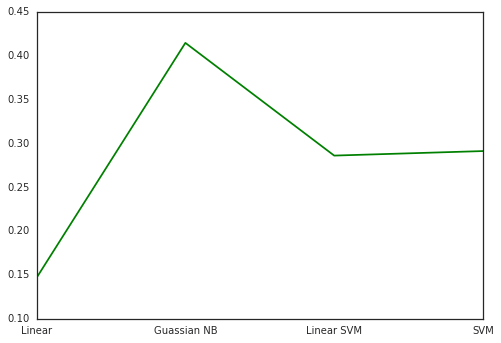

In [34]:
import pylab
pylab.figure(1)
x = range(4)
pylab.xticks(x, tup_df[0])
pylab.plot(x,tup_df[1],"g")
pylab.show()

Select Linear SVM as its MSE is lowest and predicting the values

In [35]:
cc_target = SVM_model.predict(cc1_test)
cc_target_df = pd.DataFrame(cc_target,columns = ['Target'])
cc_target_df.head(5)

,Target
0,0
1,0
2,0
3,0
4,0


In [36]:
pd.DataFrame(cc_label1_test).head(5)

,0
0,0
1,0
2,0
3,0
4,0
